<a href="https://colab.research.google.com/github/MarinaWolters/Coding-Tracker/blob/master/HandsOn11_DataStreams_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series and Data Streams

In this notebook, we will explore a time series dataset and study how to process data streams. 

##Dataset

We will use two COVID-19 related datasets in this notebook. 

The first dataset comes from the [COVID Tracking Project](https://covidtracking.com/data/) which reported new daily case rates `positiveIncrease` along with several other measures such as new total hospitalizations, number of individuals in ICU, etc. We will specifically use the variable `positiveIncrease` reported every day for each state. 
<div>
<img src="https://images.ctfassets.net/o2ll9t4ee8tq/1qiUiDsbasRwZLi5A6shSB/2f58ba998808e6ed0bcd9e137a97ba4b/86609535-48149080-bf69-11ea-9c4f-ffe056051e2b.png?w=1200&fl=progressive&q=50" width="500"/>
</div>

The second dataset comes from [prior research](http://wwbp.org/papers/jgim-2020.pdf) (courtesy Prof Sharath Guntuku) on developing machine learning based mental health estimates and symptom mentions from Twitter posts across the U.S during COVID-19. This data contains daily measures of change in sentiment, expressions of loneliness, and anxiety estimated using pre-trained models, along with number of tweets related to COVID-19, and mentions of different symptom related keywords per state.  
<div>
<img src="https://pbs.twimg.com/media/EWTWGyYWkAA82a5?format=jpg" width="500"/>
</div>


Both these datasets were populated for about a year (March 2020 to March 2021). Our goal in this notebook is to assess: 
- how daily case rates, number of COVID-19 related tweets, and overall Twitter sentiment changed over time,
- the stationarity and seasonality of Twitter sentiment around this time, and
- the use of ARIMA to model Twitter sentiment

On the same dataset, we will also explore the application of Spark Streaming in processing this data (if it were to be made available on a daily interval) to evaluate if U.S. state characteristics (for e.g. population density) and Twitter estimates can predict new case rates. 

### Preliminaries

**Install and import the required libraries**

In [ ]:
# install libraries if missing
!pip install pandasql
!pip install creme
!pip install pmdarima

# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import cv2
import requests 
from imutils import paths
from pandas import Series
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.5 MB/s eta 0:00:00


In [ ]:
# Some defaults for readable plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams["figure.figsize"] = (10, 5)

<ipython-input-3-f35f90d62528>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Loading data

In [ ]:
# Pull COVID case data from The COVID Tracking Project
covid_cases_url = 'https://storage.googleapis.com/penn-cis5450/all-states-history.csv'
covid_cases_df = pd.read_csv(covid_cases_url)

# State is represented as 2-alphabet code in the data
covid_cases_df.rename(columns={'state':'code'},inplace=True)

# Convert date into pandas datetime object
covid_cases_df.date = pd.to_datetime(covid_cases_df.date)

covid_cases_df.head()

,date,code,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-03-07,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,...,1731628.0,0,NaN,NaN,NaN,NaN,NaN,0,1731628.0,0
1,2021-03-07,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,...,2323788.0,2347,NaN,NaN,119757.0,NaN,2323788.0,2347,NaN,0
2,2021-03-07,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,...,2736442.0,3380,NaN,NaN,NaN,481311.0,NaN,0,2736442.0,3380
3,2021-03-07,AS,0.0,NaN,0,NaN,NaN,NaN,NaN,0,...,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0
4,2021-03-07,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,...,7908105.0,45110,580569.0,NaN,444089.0,NaN,3842945.0,14856,7908105.0,45110


In [ ]:
# US 2-alphabet code to state mapping
codes_url = 'https://storage.googleapis.com/penn-cis5450/us_states_codes.csv'
codes_df = pd.read_csv(codes_url)
codes_df.rename(columns={'State':'state','Code':'code'},inplace=True)
codes_df.drop('Abbrev',axis=1,inplace=True)

# US Population Density
pop_url = 'https://storage.googleapis.com/penn-cis5450/us_pop_density.csv'
pop_df = pd.read_csv(pop_url)
pop_df.rename(columns={'State':'state'},inplace=True)

# Merge state pop density and codes
pop_df = pd.merge(pop_df,codes_df,on='state')
pop_df.head()

,state,Density (/mi^2),Population,TotalArea (mi^2),code
0,New Jersey,1276.6405,9388414,8723,NJ
1,Rhode Island,1069.9623,1106341,1545,RI
2,Massachusetts,913.6378,7126375,10554,MA
3,Connecticut,746.0376,3612314,5543,CT
4,Maryland,644.6851,6257958,12406,MD


In [ ]:
#Merge case rates and US population df 
covid_cases_pop_df = pd.merge(covid_cases_df,pop_df,on='code')
covid_cases_pop_df.head()

,date,code,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease,state,Density (/mi^2),Population,TotalArea (mi^2)
0,2021-03-07,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,...,NaN,NaN,NaN,0,1731628.0,0,Alaska,1.2933,738023,665384
1,2021-03-06,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,...,NaN,NaN,NaN,0,1731628.0,0,Alaska,1.2933,738023,665384
2,2021-03-05,AK,305.0,NaN,2,NaN,1293.0,1293.0,33.0,3,...,NaN,NaN,NaN,0,1731628.0,7144,Alaska,1.2933,738023,665384
3,2021-03-04,AK,303.0,NaN,0,NaN,1290.0,1290.0,32.0,5,...,NaN,NaN,NaN,0,1724484.0,13466,Alaska,1.2933,738023,665384
4,2021-03-03,AK,303.0,NaN,1,NaN,1285.0,1285.0,26.0,-1,...,NaN,NaN,NaN,0,1711018.0,6358,Alaska,1.2933,738023,665384


In [ ]:
covid_cases_pop_df.columns

Index(['date', 'code', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease',

In [ ]:
# Load Twitter estimates data
covid_tw_url = 'https://storage.googleapis.com/penn-cis5450/covid-data.csv'
covid_tw_df = pd.read_csv(covid_tw_url)
covid_tw_df.rename(columns={'Date':'date','State':'state','total_count':'num_symptom_tweets',
                            '# COVID Tweets':'num_covid_tweets'},inplace=True)

cols_to_keep = ['state','date','num_covid_tweets','num_symptom_tweets', 'Relative Twitter Sentiment',
 'Relative Twitter Loneliness','Relative Twitter Anxiety']

covid_tw_df = covid_tw_df[cols_to_keep]

# Split date into year, month, and day
covid_tw_df[["Year", "Month", "Day of the Month"]] = covid_tw_df["date"].str.split("-", expand = True)
covid_tw_df.date = pd.to_datetime(covid_tw_df.date)
# Calculate proportion of tweets mentioning symptoms among the total COVID-19 tweets
covid_tw_df['prop_symptom_tweets'] = covid_tw_df['num_symptom_tweets']/covid_tw_df['num_covid_tweets']
covid_tw_df.tail()

,state,date,num_covid_tweets,num_symptom_tweets,Relative Twitter Sentiment,Relative Twitter Loneliness,Relative Twitter Anxiety,Year,Month,Day of the Month,prop_symptom_tweets
18312,Wyoming,2021-03-07,8,0,-5.674436,4.519918,0.137970,2021,03,07,0.000000
18313,Wyoming,2021-03-08,1,0,1.153612,-1.066367,-0.930473,2021,03,08,0.000000
18314,Wyoming,2021-03-09,11,1,1.612906,-5.026231,-1.885659,2021,03,09,0.090909
18315,Wyoming,2021-03-10,7,0,-2.960584,6.794961,-0.495116,2021,03,10,0.000000
18316,Wyoming,2021-03-10,30,0,-2.960584,6.794961,-0.495116,2021,03,10,0.000000


In [ ]:
#Merge Twitter and case dfs
covid_df = pd.merge(covid_tw_df, covid_cases_pop_df, on = ['date','state'])
covid_df.tail()

,state,date,num_covid_tweets,num_symptom_tweets,Relative Twitter Sentiment,Relative Twitter Loneliness,Relative Twitter Anxiety,Year,Month,Day of the Month,...,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease,Density (/mi^2),Population,TotalArea (mi^2)
17877,Wyoming,2021-03-01,18,1,1.407508,0.331779,0.034158,2021,03,01,...,NaN,NaN,NaN,227343.0,473,640594.0,3878,5.9685,579495,97813
17878,Wyoming,2021-03-02,35,2,7.237015,3.057975,1.182584,2021,03,02,...,NaN,NaN,NaN,227593.0,250,641380.0,786,5.9685,579495,97813
17879,Wyoming,2021-03-04,29,2,-2.476304,-0.894124,0.213873,2021,03,04,...,NaN,NaN,NaN,228285.0,336,646179.0,2703,5.9685,579495,97813
17880,Wyoming,2021-03-06,8,0,-0.038006,0.859791,4.857071,2021,03,06,...,NaN,NaN,NaN,228661.0,0,649293.0,0,5.9685,579495,97813
17881,Wyoming,2021-03-07,8,0,-5.674436,4.519918,0.137970,2021,03,07,...,NaN,NaN,NaN,228661.0,0,649293.0,0,5.9685,579495,97813


#Time Series Analysis

Let's start by looking at the positive cases in 5 states and then restrict our analyses to only the state of Pennsylvania (PA). The same could be done across states. 

*Question*: If we were given number of cases per day per state, what preprocessing would I need to do before comparing how states are doing? 

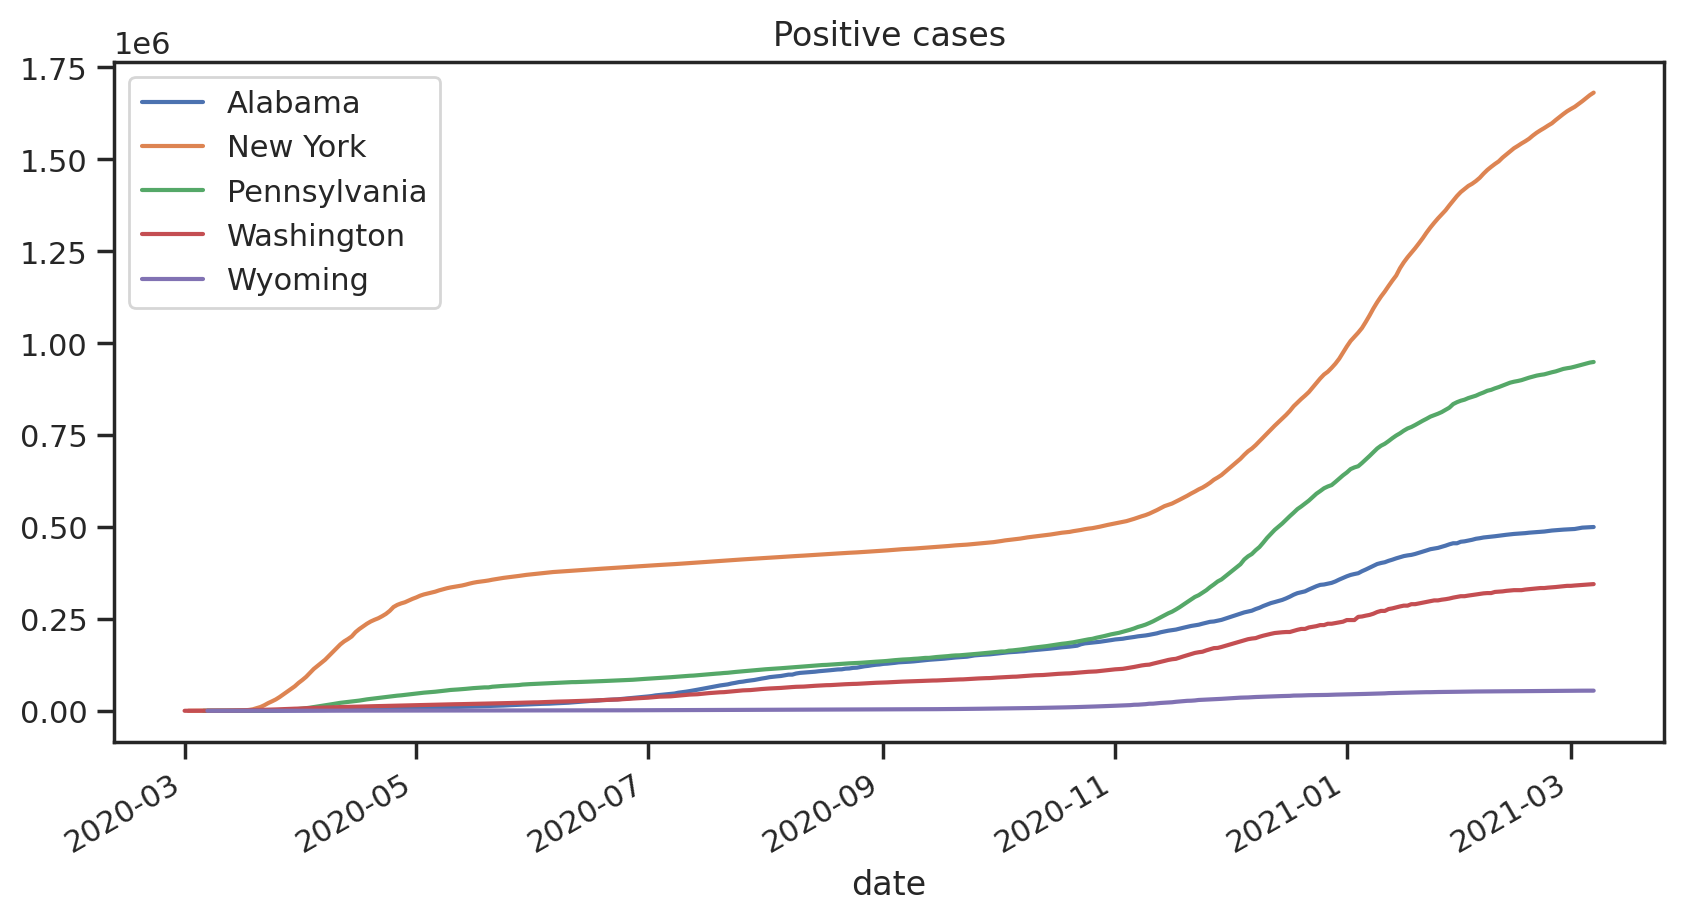

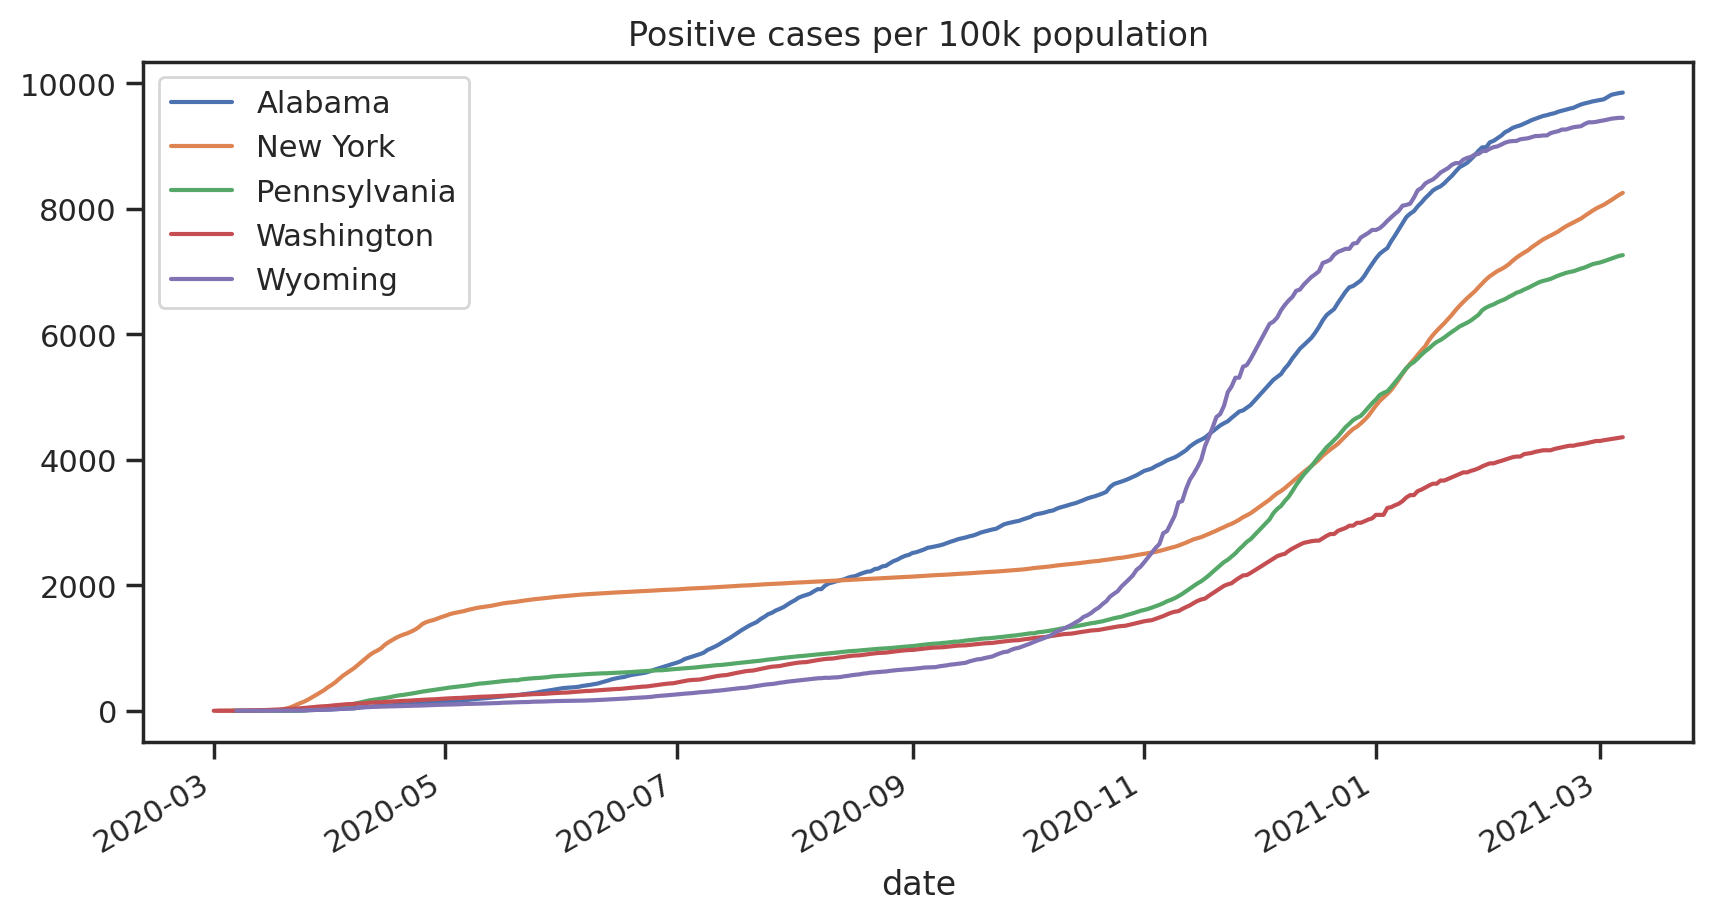

In [ ]:
# select 5 states 
covid_5states = covid_df.loc[(covid_df.state=='Pennsylvania')|(covid_df.state=='New York')|(covid_df.state=='Wyoming')|(covid_df.state=='Alabama')|(covid_df.state=='Washington')].copy()
# plot `positive` per state
covid_5states.set_index('date').groupby('state')['positive'].plot(legend=True)
plt.title('Positive cases')
plt.show()

#plot per capita cases
covid_5states['positive_per_capita_per_100k'] = covid_5states['positive']*100000/covid_5states['Population']
covid_5states.set_index('date').groupby('state')['positive_per_capita_per_100k'].plot(legend=True)
plt.title('Positive cases per 100k population')
plt.show()

What do the two plots convey? 

In [ ]:
#restricting to only PA
covid_pa = covid_df.loc[covid_df.state=='Pennsylvania'].copy()
covid_pa.set_index('date',inplace=True)

<Axes: title={'center': 'New daily cases in PA'}, xlabel='date'>

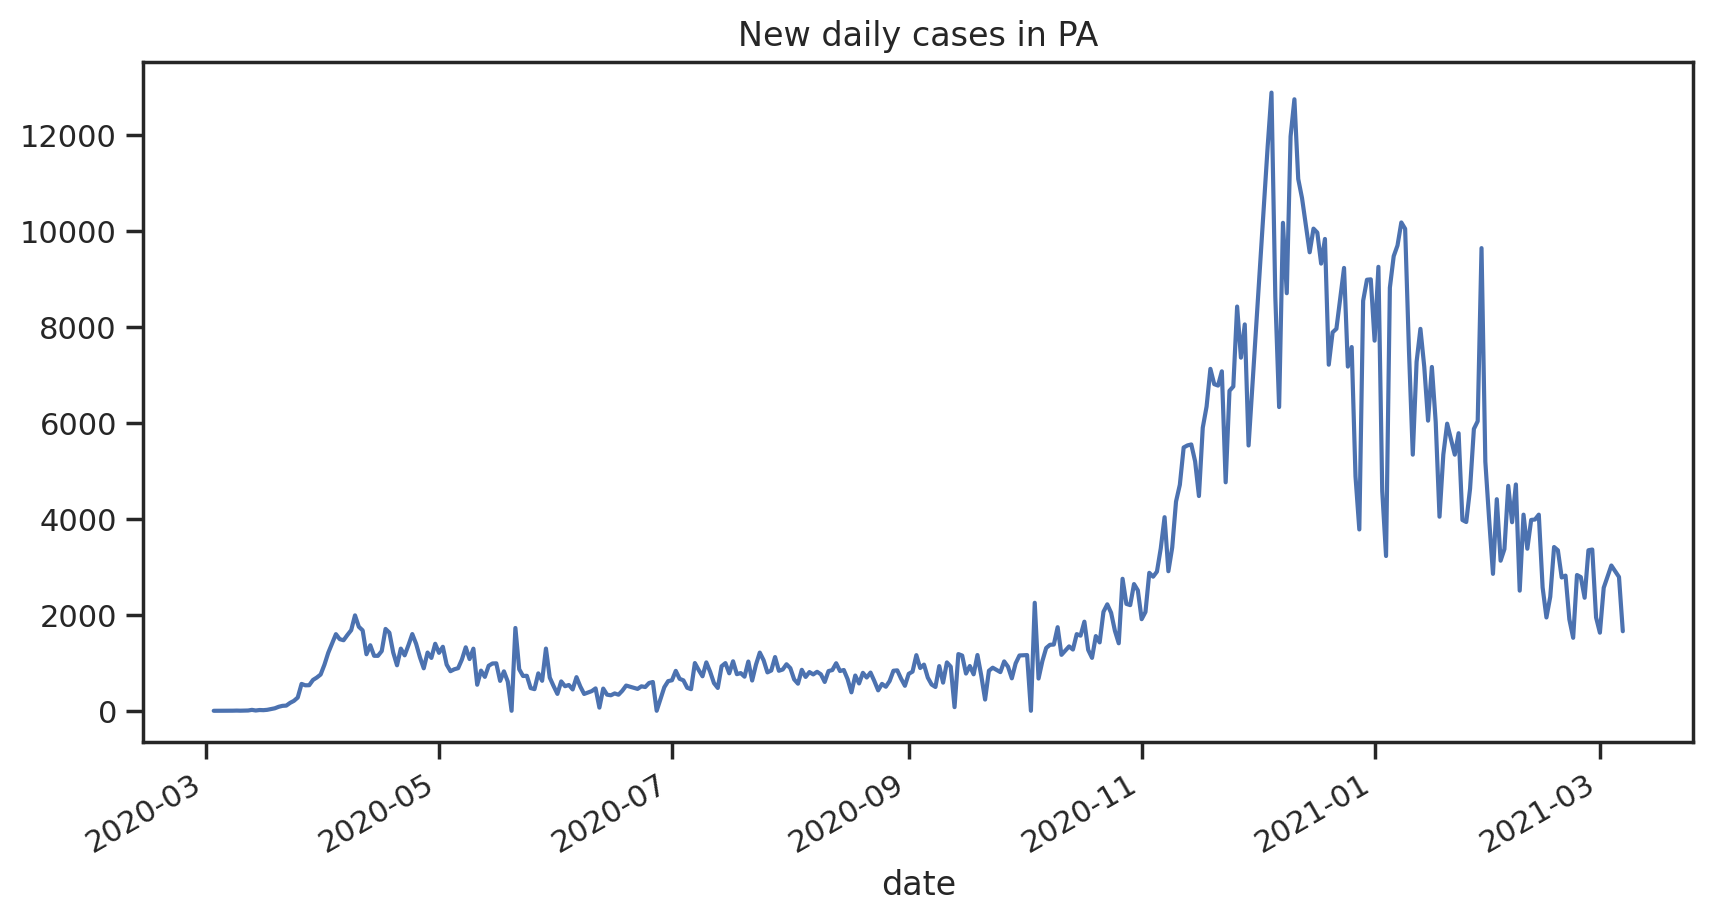

In [ ]:
# Plotting new daily cases
covid_pa['positiveIncrease'].plot(title='New daily cases in PA')

<Axes: xlabel='date'>

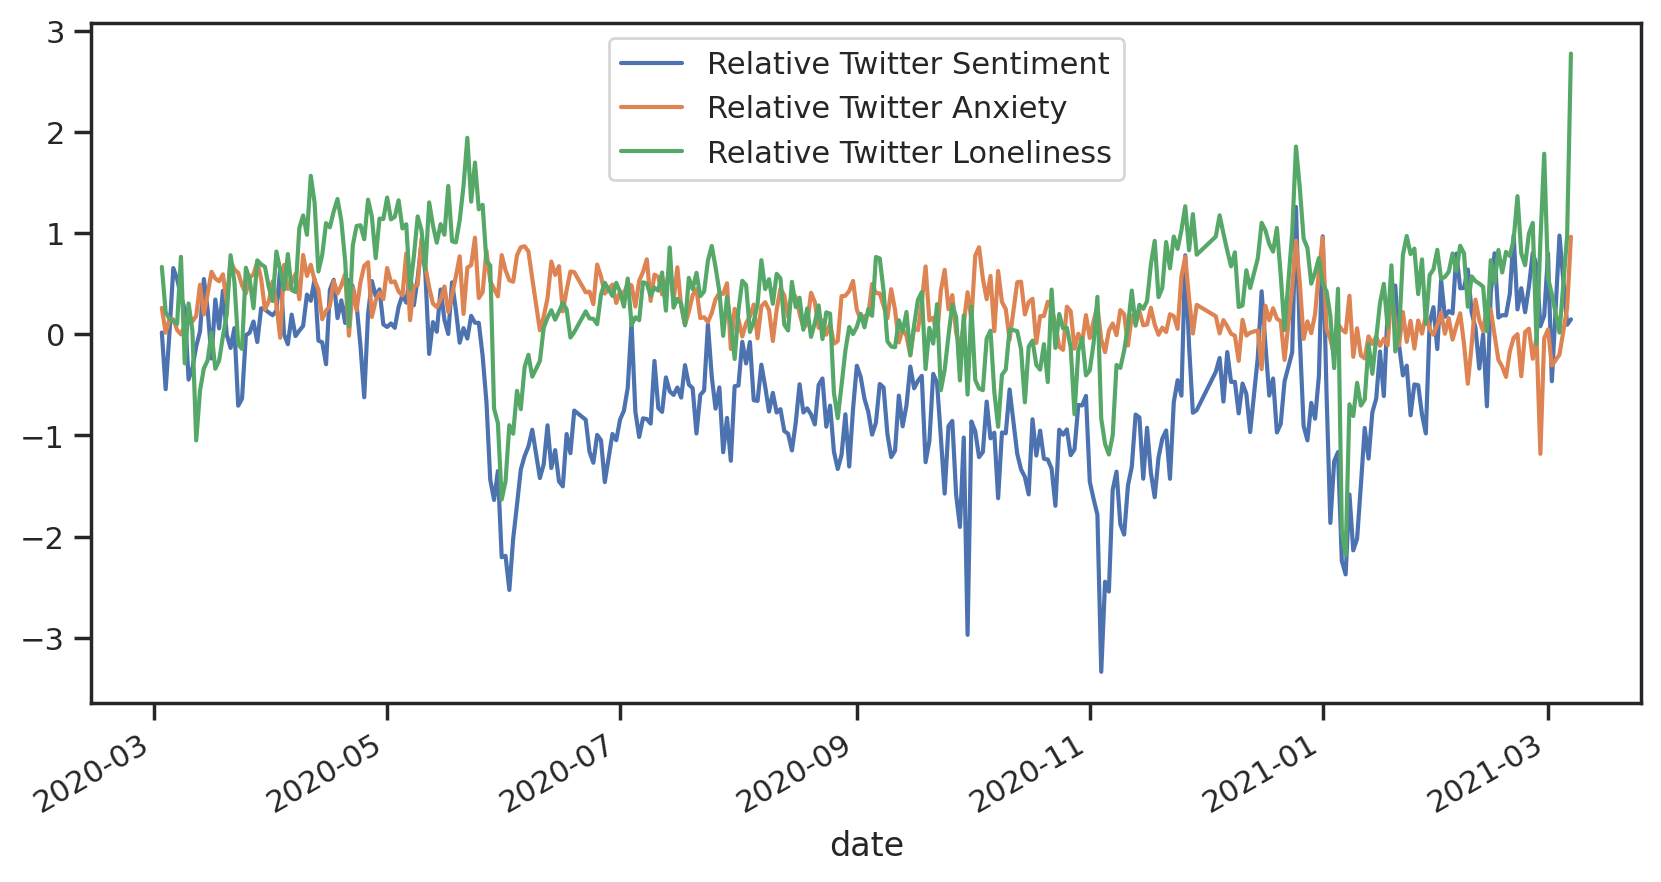

In [ ]:
# Plotting estimates of sentiment, anxiety, and loneliness expressions from Twitter
covid_pa[['Relative Twitter Sentiment','Relative Twitter Anxiety','Relative Twitter Loneliness']].plot()

<Axes: xlabel='date'>

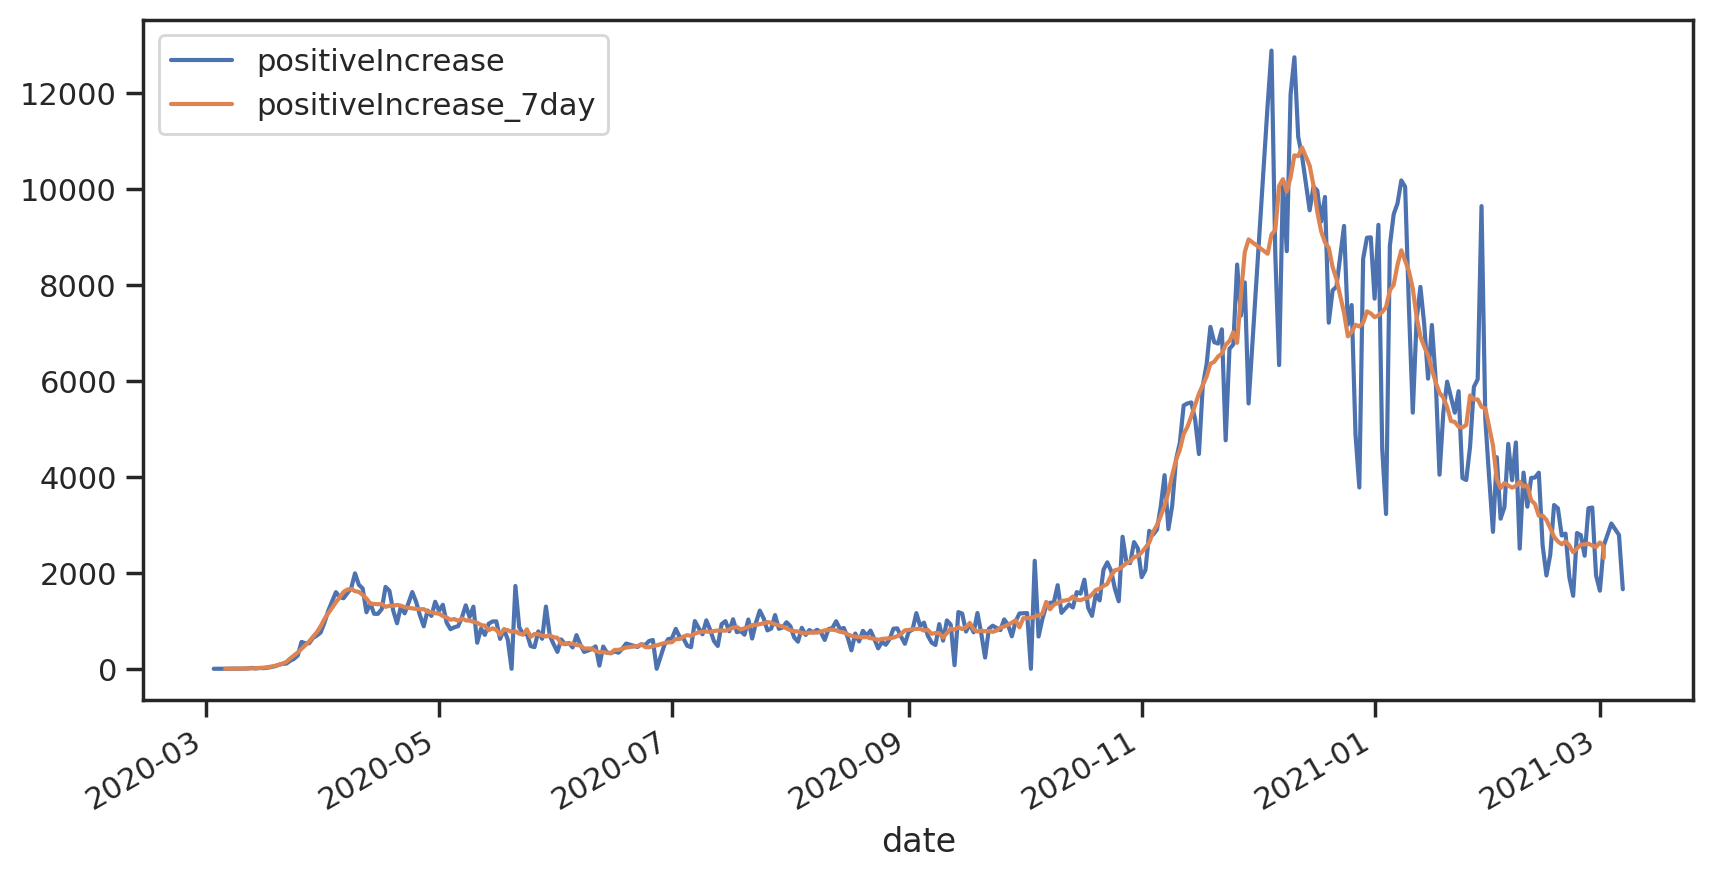

In [ ]:
# Calculate 7-day average of new cases
covid_pa['positiveIncrease_7day'] = covid_pa.positiveIncrease.rolling(7).mean().shift(-3)
covid_pa[['positiveIncrease','positiveIncrease_7day']].plot()

*Question*: What does it mean for a time-series to be stationary? Do you think case rates are stationary?

We can test this statistically using ADF.

In [ ]:
# Function to test for stationarity
def test_stationarity(timeseries, lags=None):
  rolmean = Series.rolling(timeseries, center=False, window=12).mean()
  rolstd = Series.rolling(timeseries, center=False, window=12).std()

  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  print('Results of ADF Test:')
  if lags:
    dftest = adfuller(timeseries, autolag=None, maxlag=lags)
  else:
    dftest = adfuller(timeseries, autolag='AIC')

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags', 'Observations'])
                     
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

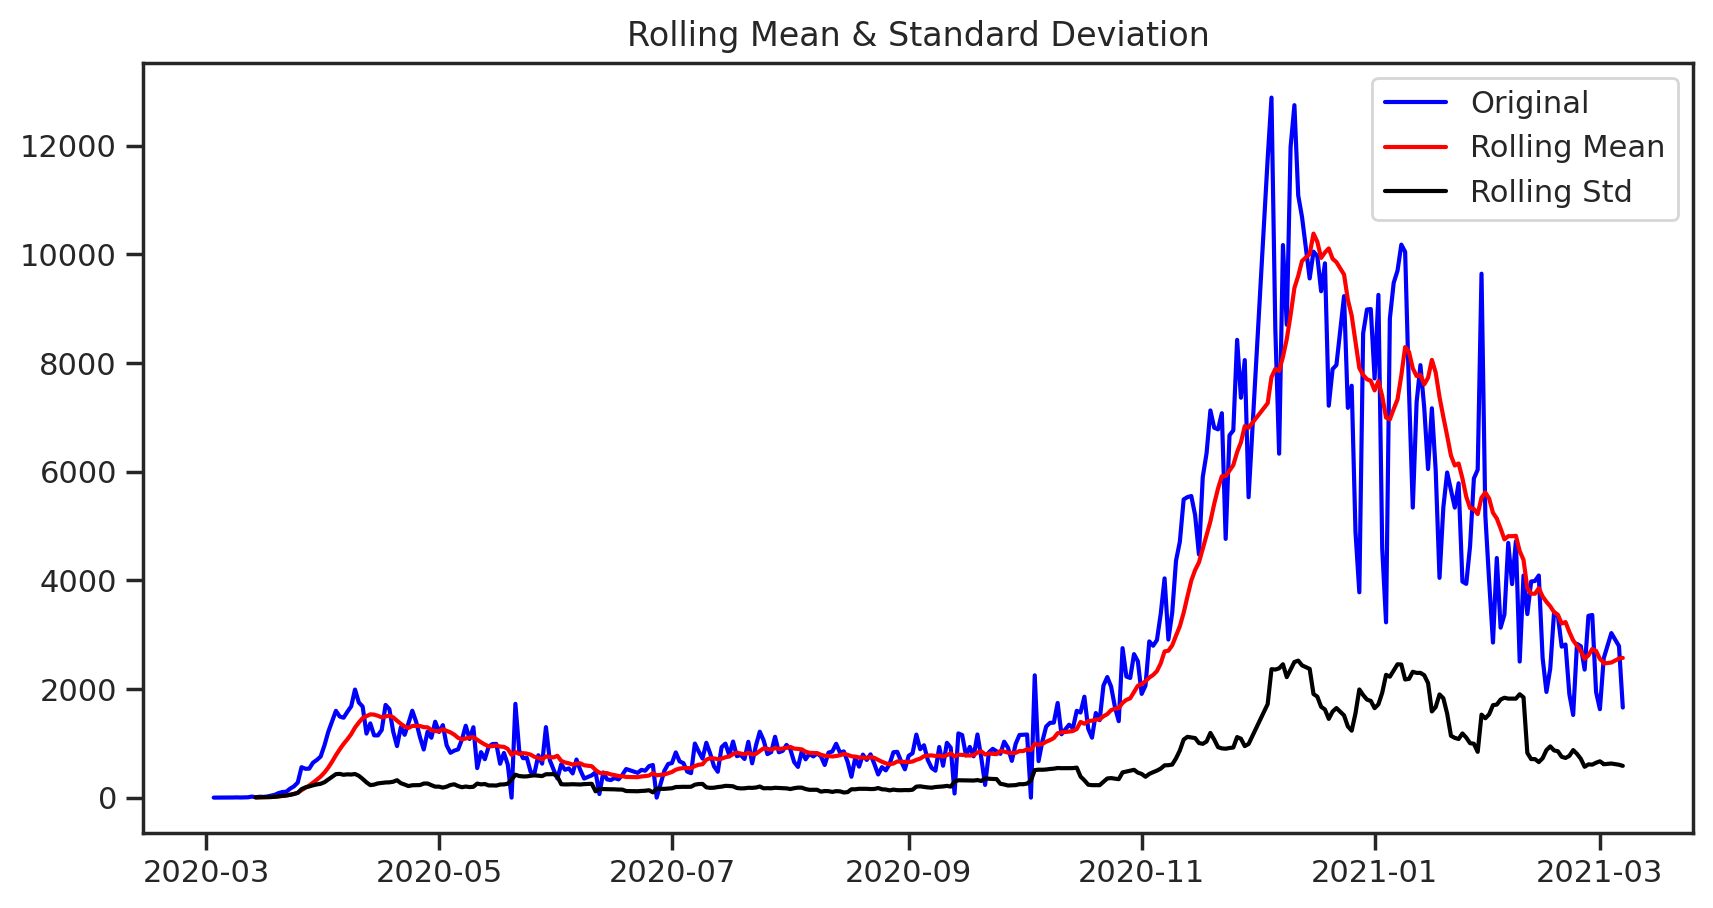

Results of ADF Test:
Test Statistic           -1.430819
p-value                   0.567415
#Lags                     9.000000
Observations            348.000000
Critical Value (1%)      -3.449282
Critical Value (5%)      -2.869881
Critical Value (10%)     -2.571214
dtype: float64


In [ ]:
test_stationarity(covid_pa['positiveIncrease'])

*Question*: How do we interpret the values of the test statistic? 

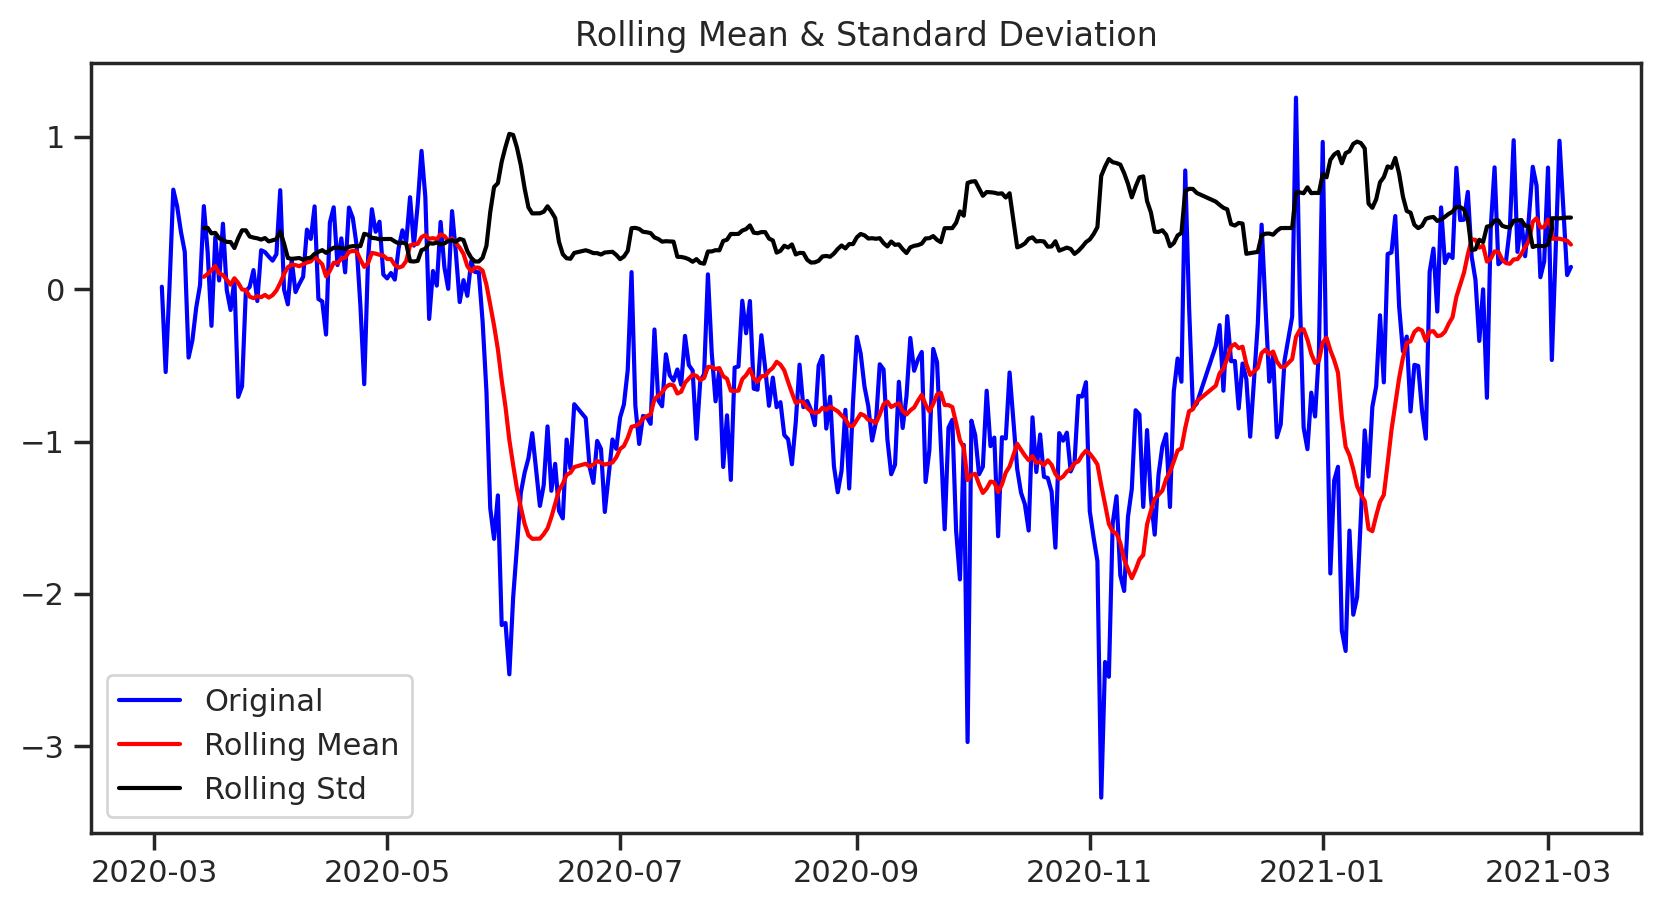

Results of ADF Test:
Test Statistic           -2.983354
p-value                   0.036478
#Lags                     7.000000
Observations            350.000000
Critical Value (1%)      -3.449173
Critical Value (5%)      -2.869833
Critical Value (10%)     -2.571188
dtype: float64


In [ ]:
# Testing stationarity for Twitter sentiment
test_stationarity(covid_pa['Relative Twitter Sentiment'],7)

date
2020-03-09    Axes(0.125,0.11;0.775x0.77)
2020-03-16    Axes(0.125,0.11;0.775x0.77)
2020-03-23    Axes(0.125,0.11;0.775x0.77)
2020-03-30    Axes(0.125,0.11;0.775x0.77)
2020-04-06    Axes(0.125,0.11;0.775x0.77)
2020-04-13    Axes(0.125,0.11;0.775x0.77)
2020-04-20    Axes(0.125,0.11;0.775x0.77)
2020-04-27    Axes(0.125,0.11;0.775x0.77)
2020-05-04    Axes(0.125,0.11;0.775x0.77)
2020-05-11    Axes(0.125,0.11;0.775x0.77)
2020-05-18    Axes(0.125,0.11;0.775x0.77)
2020-05-25    Axes(0.125,0.11;0.775x0.77)
2020-06-01    Axes(0.125,0.11;0.775x0.77)
2020-06-08    Axes(0.125,0.11;0.775x0.77)
2020-06-15    Axes(0.125,0.11;0.775x0.77)
2020-06-22    Axes(0.125,0.11;0.775x0.77)
2020-06-29    Axes(0.125,0.11;0.775x0.77)
2020-07-06    Axes(0.125,0.11;0.775x0.77)
2020-07-13    Axes(0.125,0.11;0.775x0.77)
2020-07-20    Axes(0.125,0.11;0.775x0.77)
2020-07-27    Axes(0.125,0.11;0.775x0.77)
2020-08-03    Axes(0.125,0.11;0.775x0.77)
2020-08-10    Axes(0.125,0.11;0.775x0.77)
2020-08-17    Axes(0.125,0.11

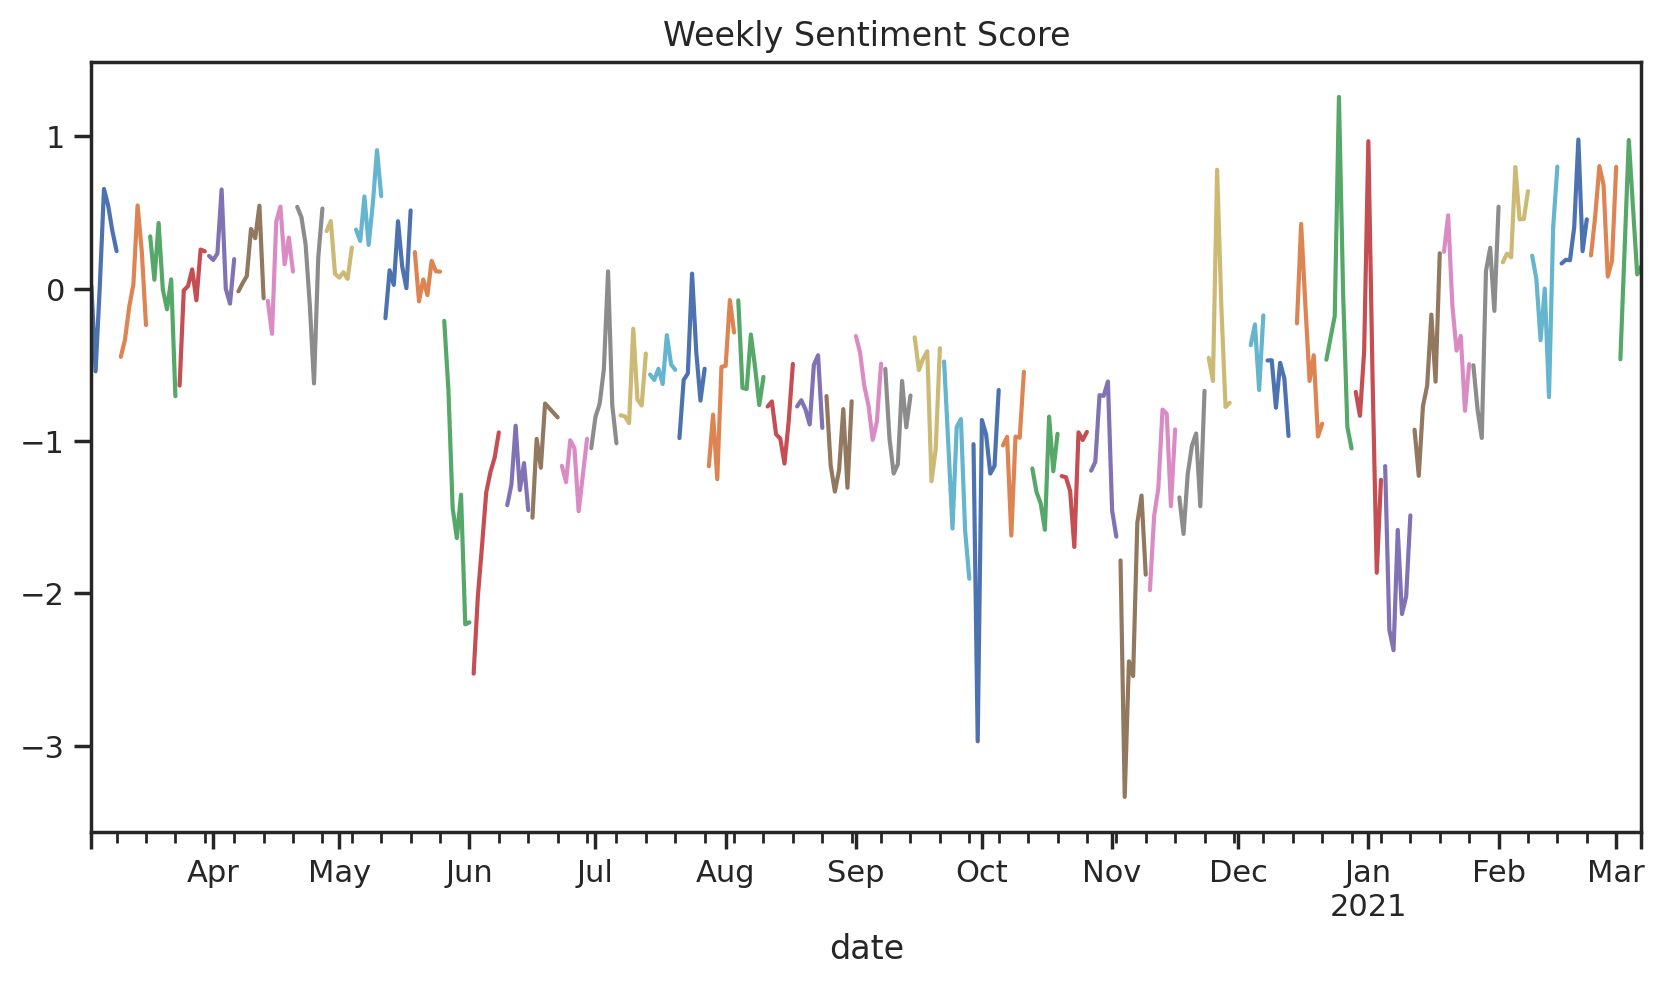

In [ ]:
covid_pa.resample('W-MON')['Relative Twitter Sentiment'].plot(title= 'Weekly Sentiment Score')

Note the pattern in sentiment in every week. 

We could look at the effect of subtracting the rolling mean. 

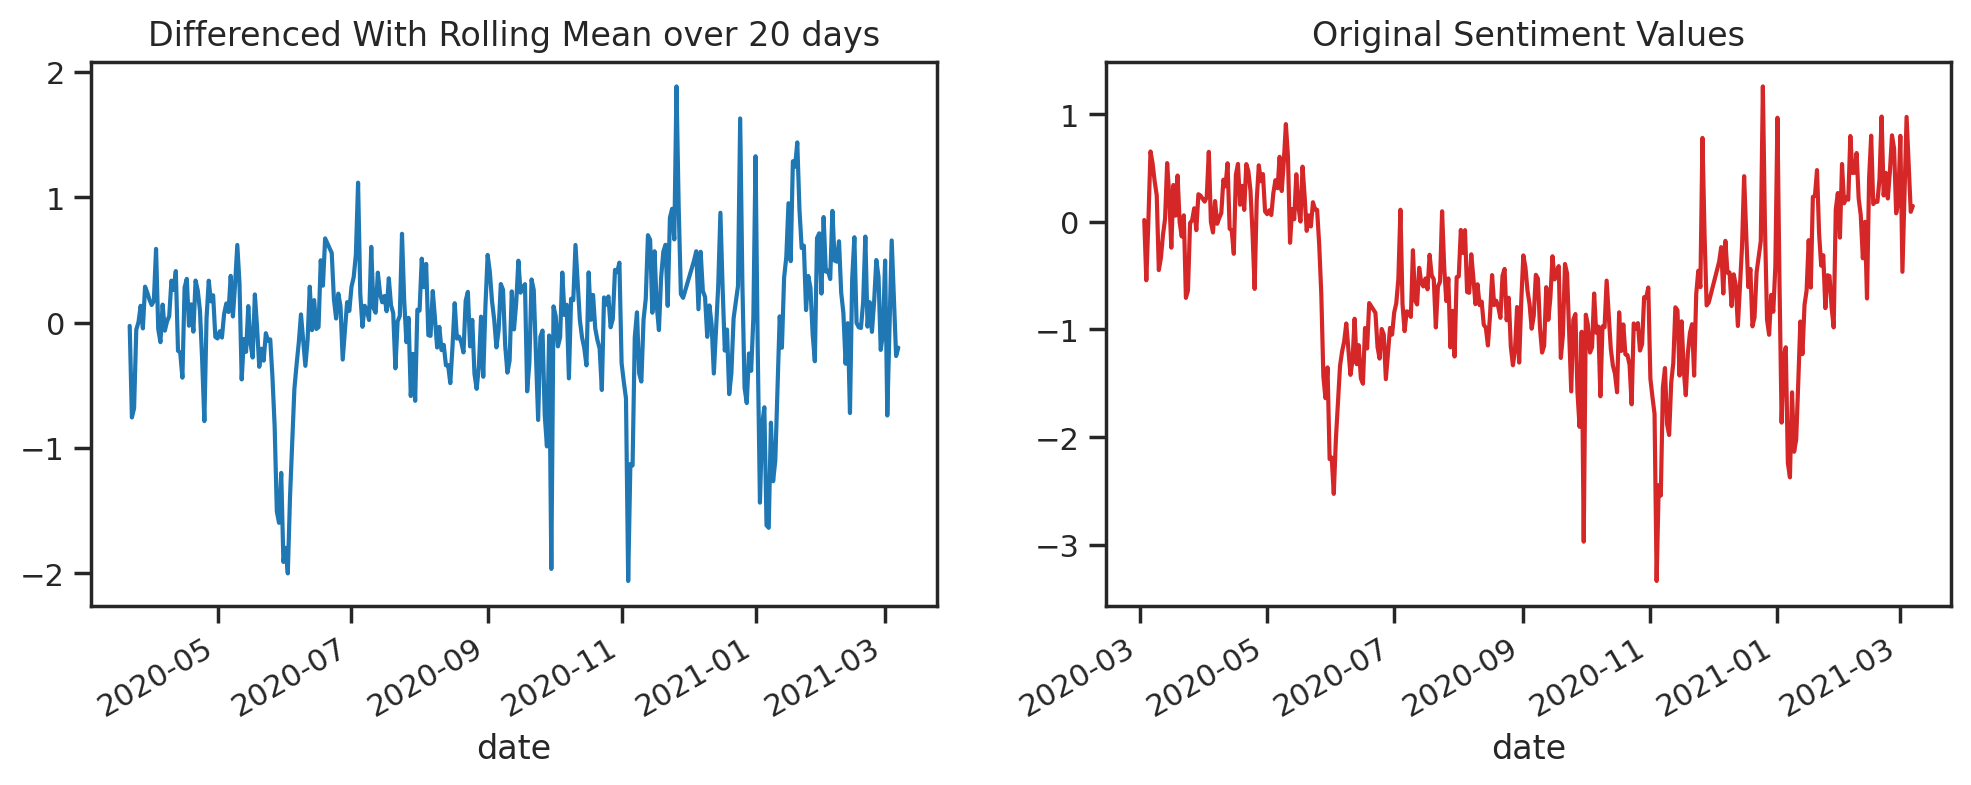

In [ ]:
#Calculate rolling mean
rolling_mean = covid_pa['Relative Twitter Sentiment'].rolling(window = 20).mean()
#Subtract rolling mean
covid_pa_sentiment_rolled_detrended = covid_pa['Relative Twitter Sentiment'] - rolling_mean

ax1 = plt.subplot(121)
covid_pa_sentiment_rolled_detrended.plot(figsize=(12,4),color="tab:blue", 
                                         title="Differenced With Rolling Mean over 20 days", ax=ax1);
ax2 = plt.subplot(122)
covid_pa['Relative Twitter Sentiment'].plot(figsize=(12,4), color="tab:red", 
                                            title="Original Sentiment Values", ax=ax2);


Now let's test if the de-trended line is stationary


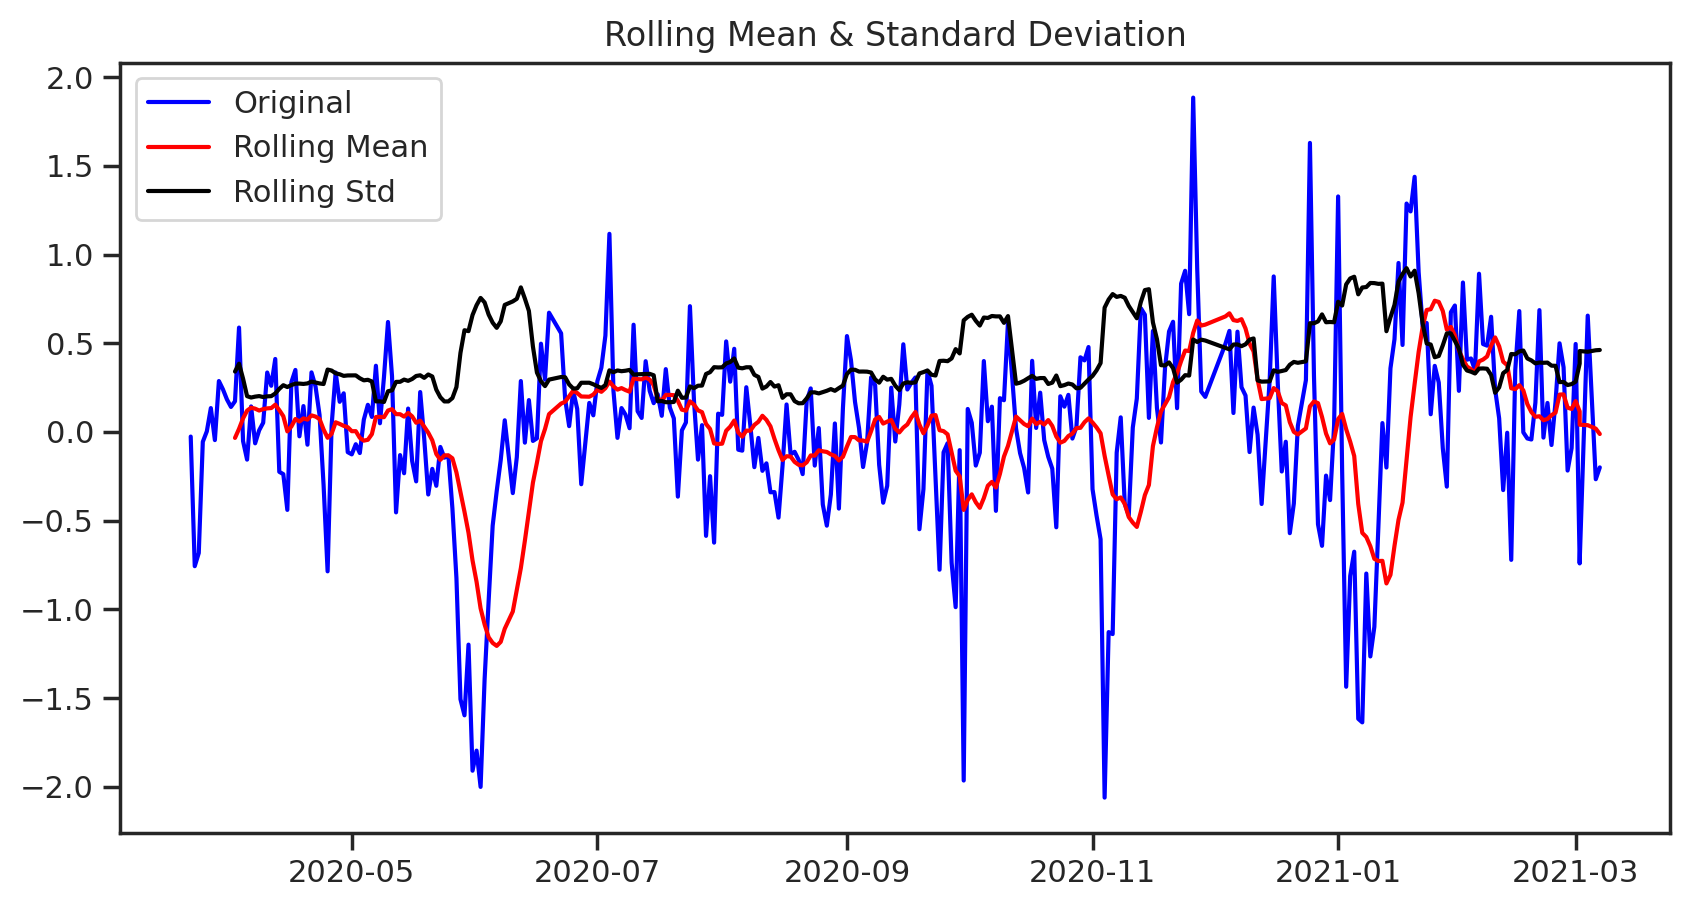

Results of ADF Test:
Test Statistic         -5.842720e+00
p-value                 3.744664e-07
#Lags                   2.000000e+00
Observations            3.360000e+02
Critical Value (1%)    -3.449963e+00
Critical Value (5%)    -2.870181e+00
Critical Value (10%)   -2.571373e+00
dtype: float64


In [ ]:
#
test_stationarity(covid_pa_sentiment_rolled_detrended.dropna())

Another way to find out the lag parameter is to look at the autocorrelation plot (across different lag values)

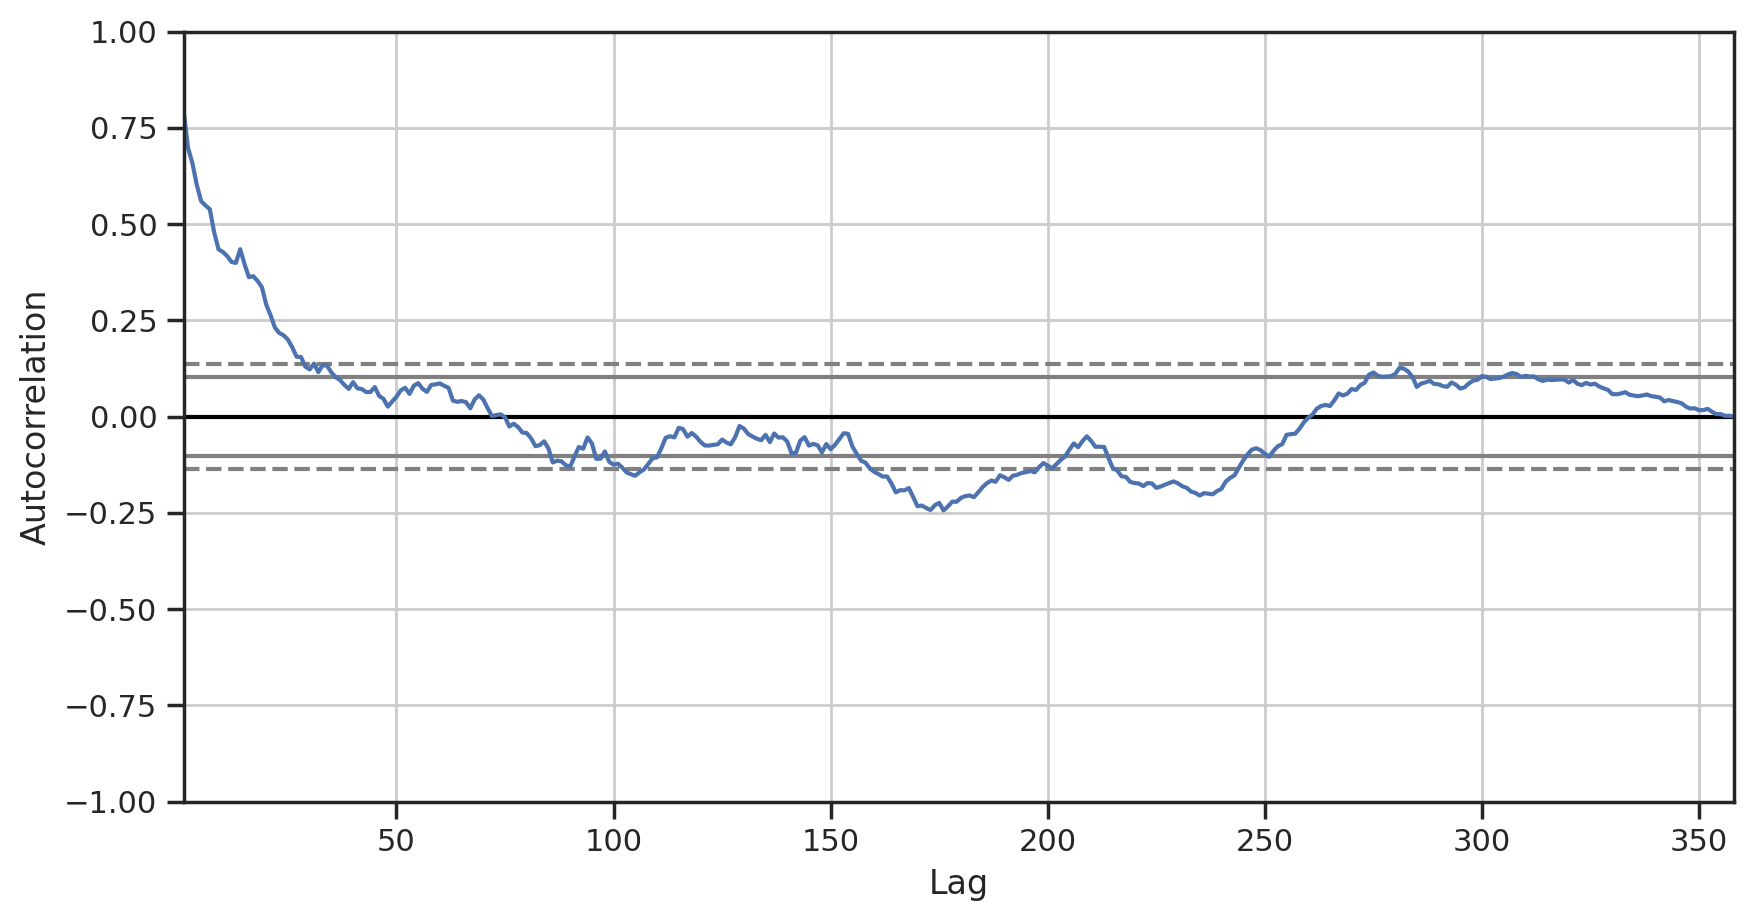

In [ ]:
from pandas.plotting import autocorrelation_plot
 
autocorrelation_plot(covid_pa['Relative Twitter Sentiment'])
plt.show()

Note that the dotted lines indicate the signifcance (p-value). 

Now, let's see if we can forecast Twitter sentiment

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

# split into train and test sets
X = covid_pa['Relative Twitter Sentiment']
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(20,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=-1.256071, expected=-0.794098
predicted=-1.071684, expected=-0.822434
predicted=-1.163050, expected=-1.428561
predicted=-1.582602, expected=-0.924645
predicted=-1.032570, expected=-1.370929
predicted=-1.596973, expected=-1.610929
predicted=-1.362159, expected=-1.217784
predicted=-1.331691, expected=-1.031878
predicted=-1.156394, expected=-0.951643
predicted=-0.858940, expected=-1.429066
predicted=-1.790456, expected=-0.671280
predicted=-1.038136, expected=-0.454567
predicted=-0.644458, expected=-0.607089
predicted=-0.603704, expected=0.779962
predicted=0.225815, expected=-0.113887
predicted=-0.215396, expected=-0.776887
predicted=-0.750255, expected=-0.750545
predicted=-0.747046, expected=-0.371675
predicted=-0.488145, expected=-0.235315
predicted=-0.359798, expected=-0.665902
predicted=-0.522745, expected=-0.176462
predicted=-0.439622, expected=-0.472062
predicted=-0.537235, expected=-0.471016
predicted=-0.469450, expected=-0.782647
predicted=-0.564620, expected=-0.487795
pr

In [ ]:
pred_series = pd.Series(predictions,index=test.index)

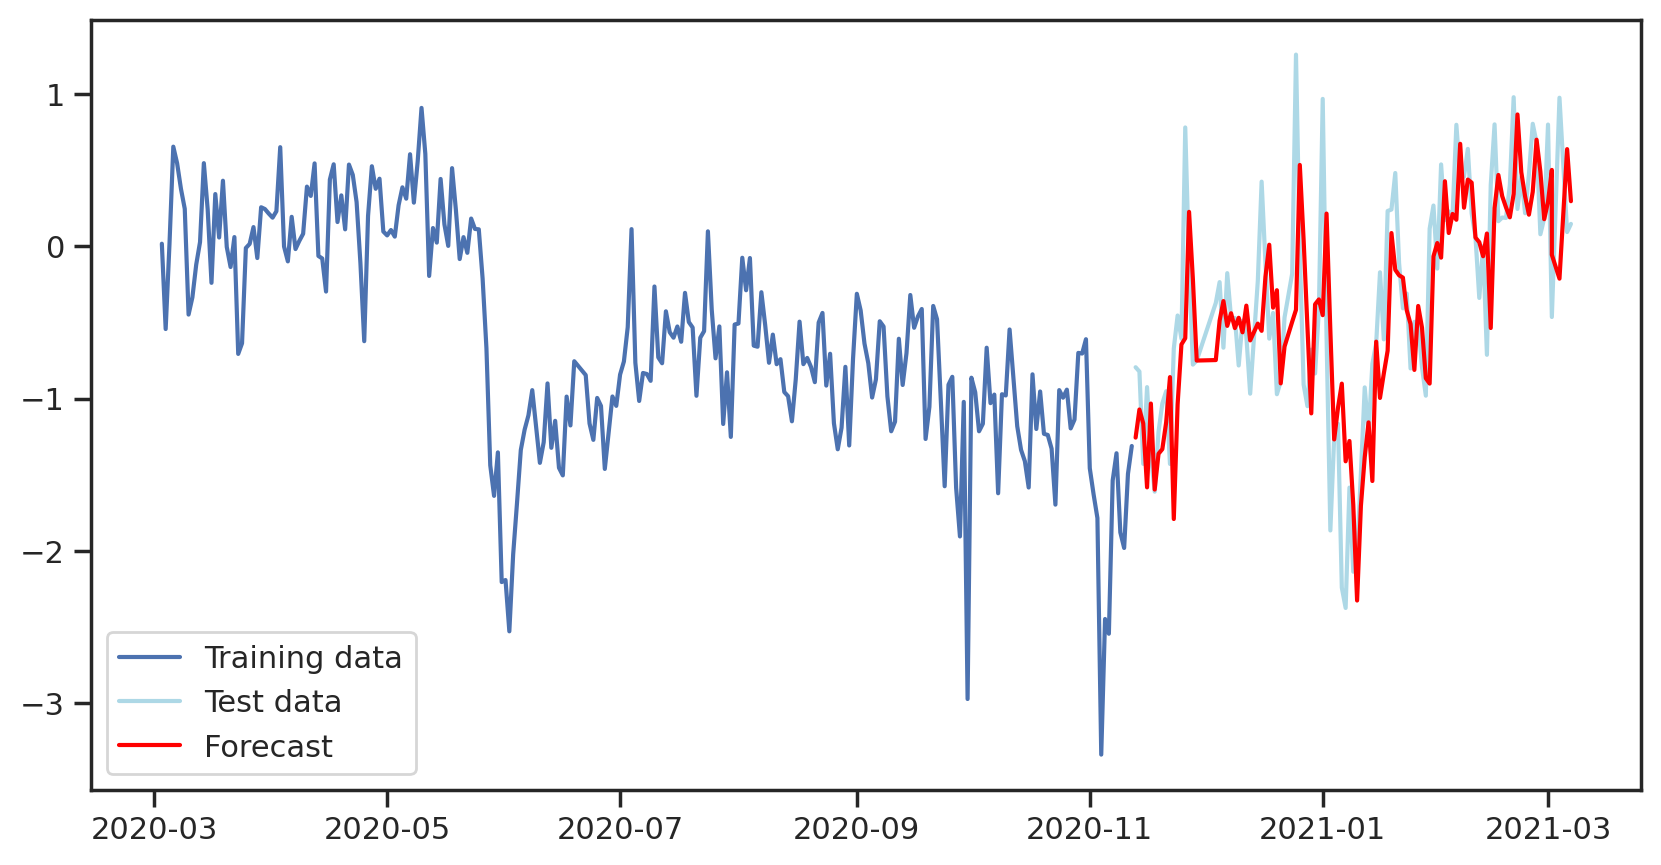

In [ ]:
# plot forecasts against actual outcomes
import matplotlib.pyplot as plt
plt.plot(train,label="Training data")
plt.plot(test,color='lightblue', label="Test data")
plt.plot(pred_series, color='red', label="Forecast")
plt.legend()
plt.show()

Note that this data is particularly noisy because we're looking at the effect of an exogenous shock the Twitter world has not previously seen. If we were to look at seasonality in sentiment across years, the pattern would be very different. Take a look at this excellent resource: [Hedonometer](https://hedonometer.org/timeseries/en_all/?from=2008-09-09&to=2022-07-25) and the accompanying [paper](https://www.uvm.edu/~storylab/share/papers/dodds2014a/dodds2014a.pdf). 

In cases where p, q, and q are not obvious, we can tune them just like we did for the hyperparameters for linear regression. This is a good resource: http://alkaline-ml.com/pmdarima/ for parameter tuning in ARIMA.

#Streaming!

We've looked at the entirety of the 1 year time series data together. What if we got the COVID-19 case data and Twitter sentiment data as a stream? 

Go Apache Storm!

In [ ]:
import os

#!apt install openjdk-8-jdk-headless
!wget https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install findspark

#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin/hadoop3"

import findspark

findspark.init('./spark-3.3.2-bin-hadoop3')

--2023-04-05 21:15:17--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M   238MB/s    in 1.2s    

2023-04-05 21:15:18 (238 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Installation of Storm, StreamParse and Their Support Libraries

In [ ]:
!wget https://raw.githubusercontent.com/technomancy/leiningen/stable/bin/lein
!wget https://archive.apache.org/dist/storm/apache-storm-1.2.3/apache-storm-1.2.3.tar.gz
!tar zxvf apache-storm-1.2.3.tar.gz
!chmod a+x ./lein
!chmod a+x apache-storm-1.2.3/bin/storm
!bash lein version
!sparse quickstart wordcount
!pip install streamparse
#!cat wordcount/project.clj | sed s/1.1.0/1.2.3/ > wordcount/project2.clj
#!mv wordcount/project2.clj wordcount/project.clj
#!cd /content/wordcount ; sparse run
!pip install pandasql
!pip install creme

os.environ['LEIN_ROOT']='1'
os.environ['PATH'] = os.environ['PATH'] + ':/content/apache-storm-1.2.3/bin/:/content'

--2023-04-05 21:15:30--  https://raw.githubusercontent.com/technomancy/leiningen/stable/bin/lein
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13958 (14K) [text/plain]
Saving to: ‘lein.1’

lein.1              100%[===================>]  13.63K  --.-KB/s    in 0s      

2023-04-05 21:15:30 (53.8 MB/s) - ‘lein.1’ saved [13958/13958]

--2023-04-05 21:15:30--  https://archive.apache.org/dist/storm/apache-storm-1.2.3/apache-storm-1.2.3.tar.gz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169095091 (161M) [application/x-gzip]
Saving to: ‘apache-storm-1.2.3.tar.gz.1’

apache-st

In the following, we will examine if case rates can be predicted by a) U.S. state characteristics, b) twitter characteristics, and c) combination of both

Note that this is a very naive prediction setup. Ideally, we would want to treat this with appropriate lag between the Xs and Y.

#Setting up StreamParse

*Question*: What are the two functional units of streamparse that were discussed in the lecture? 

Note that we have two streams: 
- COVID Cases
- Twitter sentiment
and we want to join them with U.S. state characteristics. 


We will use population density as the candidate variable here. But feel free to test the setup with several state level variables that are collected U.S. Census, RWJ, and other agencies. Here are a few resources:
- https://www.census.gov/topics/health/data.html
- https://wonder.cdc.gov/
- https://www.americashealthrankings.org/ 

Let's start with the simple case of predicting COVID Cases with State characteristics. For this, we will have: 
- one Spout: CovidCasesSpout
- one Join Bolt: CovidCasesSpout and State Pop
- one Learning Bolt: implementing incremental learning


##CovidCasesSpout

In [ ]:
#CovidCasesSpout

from streamparse.spout import Spout
import pandas as pd

covidcases_stream = []

#class CovidCasesSpout:(Spout):
class CovidCasesSpout:
  outputs= ['date', 'code', 'positiveIncrease']
  # Position of next tuple in dataframe
  inx = 0
  # Overall stream tuple id
  tid = 0

  # Open the file as a dataframe
  def initialize(self, stormconf, context):
    covid_cases_url = 'https://storage.googleapis.com/penn-cis5450/all-states-history.csv'
    self.covid_cases_df = pd.read_csv(covid_cases_url, usecols = ['date', 'state', 'positiveIncrease'])
    self.covid_cases_df.columns = ['date', 'code', 'positiveIncrease']
    #self.covid_cases_df.dropna(inplace=True)

  # Read one row, increment the pointer, return the
  # row as a list
  def next_tuple(self):
    tup = self.covid_cases_df.iloc[self.inx]
    self.inx = self.inx + 1

    # We'll wrap around if we exceed the size of the table
    if self.inx >= len(self.covid_cases_df):
      self.inx = 0

    # We have to turn the series into a list of columns.
    self.emit(tup.tolist(), tup_id=self.tid)
    self.tid = self.tid + 1

  # If a tuple was processed properly, do nothing
  def ack(self, tup_id):
    pass

  # If a tuple was processed incorrectly, we'll still
  # do nothing
  def fail(self, tup_id):
    pass

  # This would be omitted in the real code
  def emit(self, tuple, tup_id):
    global covidcases_stream
    covidcases_stream = covidcases_stream + [tuple]

In [ ]:
# Test it

covidcases_stream = []
fs = CovidCasesSpout()

fs.initialize(None, None)
for i in range(500):
  fs.next_tuple()

df_from_CovidCasesSpout = pd.DataFrame(covidcases_stream,columns=['date', 'code', 'positiveIncrease'])
df_from_CovidCasesSpout

,date,code,positiveIncrease
0,2021-03-07,AK,0
1,2021-03-07,AL,408
2,2021-03-07,AR,165
3,2021-03-07,AS,0
4,2021-03-07,AZ,1335
...,...,...,...
495,2021-02-27,TX,11073
496,2021-02-27,UT,686
497,2021-02-27,VA,1675
498,2021-02-27,VI,10


##CovidCasesAndPop_JoinBolt

In [ ]:
from streamparse.bolt import Bolt
from pystorm.component import Tuple
import pandas as pd
from pandasql import sqldf

covidcases_pop_join_stream = []

class CovidCasesAndPop_JoinBolt:
  outputs=['date', 'code', 'pop_density', 'positiveIncrease']

  def initialize(self, stormconf, context):
    codes_url = 'https://storage.googleapis.com/penn-cis5450/us_states_codes.csv'
    codes_df = pd.read_csv(codes_url)
    codes_df.rename(columns={'State':'state','Code':'code'},inplace=True)
    codes_df.drop('Abbrev',axis=1,inplace=True)

    # US Population Density
    pop_url = 'https://storage.googleapis.com/penn-cis5450/us_pop_density.csv'
    pop_df = pd.read_csv(pop_url)
    pop_df.rename(columns={'State':'state','Density (/mi^2)':'pop_density'},inplace=True)

    # Merge state pop density and codes
    self.pop_df = pd.merge(pop_df,codes_df,on='state')

  def process(self, tup):
    covid_cases_df = pd.DataFrame([tup],columns=['date','code','positiveIncrease'])
    pop_df = self.pop_df
    incremental_results = pd.merge(covid_cases_df, pop_df, on='code',how='left')[['date', 'code', 'pop_density', 'positiveIncrease']]
    '''
    incremental_results = \
      sqldf('select date, pop.code, pop_density, positiveIncrease from'\
            ' covid_cases_df cases join pop_df pop on cases.code=pop.code',
          locals()
      )
    '''
    self.emit(incremental_results.iloc[0].tolist())

  def emit(self, tuple):
    global covidcases_pop_join_stream
    covidcases_pop_join_stream = covidcases_pop_join_stream + [tuple]


In [ ]:
covidcases_pop_join_stream = []
jb = CovidCasesAndPop_JoinBolt()

jb.initialize(None, None)

for e in covidcases_stream:
  jb.process(e)

df_from_CovidCasesAndPop_JoinBolt = pd.DataFrame(covidcases_pop_join_stream,columns=['date', 'code', 'pop_density', 'positiveIncrease'])
df_from_CovidCasesAndPop_JoinBolt

,date,code,pop_density,positiveIncrease
0,2021-03-07,AK,1.2933,0
1,2021-03-07,AL,100.1715,408
2,2021-03-07,AR,58.2425,165
3,2021-03-07,AS,NaN,0
4,2021-03-07,AZ,64.2939,1335
...,...,...,...,...
495,2021-02-27,TX,114.6318,11073
496,2021-02-27,UT,41.0510,686
497,2021-02-27,VA,221.7642,1675
498,2021-02-27,VI,NaN,10


##COVIDCasesFromPop Learning Bolt
 

In [ ]:
from streamparse.bolt import Bolt
from pystorm.component import Tuple
import pandas as pd
import creme.preprocessing
import creme.linear_model

covidcases_from_pop_prediction_stream = []

class LearnBolt:
  outputs = ['predicted','actual','error']

  def initialize(self, stormconf, context):
    self.scaler = creme.preprocessing.StandardScaler()
    self.lin_reg = creme.linear_model.LinearRegression()
    self.state_code_one_hot = creme.preprocessing.OneHotEncoder('code')

  def process(self, tup):
    x = pd.Series(tup, index=['date', 'code', 'pop_density', 'positiveIncrease'])
    x.dropna(inplace=True)
    x_onehot = pd.Series(self.state_code_one_hot.fit_one(x).transform_one(x))
    y = x['positiveIncrease']
    x = pd.concat([x, x_onehot]).drop(['code','date','positiveIncrease'])

    x = self.scaler.fit_one(x).transform_one(x)
    yhat = self.lin_reg.predict_one(x)
    print('Predicted {}, actual {}, error {}'.format(yhat, y, abs(yhat - y)))
    self.emit([yhat,y,abs(yhat-y)])
    self.lin_reg.fit_one(x, y)

  def emit(self, tuple):
    global covidcases_from_pop_prediction_stream
    covidcases_from_pop_prediction_stream = covidcases_from_pop_prediction_stream + [tuple]


In [ ]:
covidcases_from_pop_prediction_stream = []
lb = LearnBolt()

lb.initialize(None, None)

for e in covidcases_pop_join_stream:
  lb.process(e)

df_from_LearnBolt = pd.DataFrame(covidcases_from_pop_prediction_stream,columns=['predicted','actual','error'])

Predicted 0.0, actual 0, error 0.0
Predicted 0.0, actual 408, error 408.0
Predicted 9.168221203056653, actual 165, error 155.83177879694335
Predicted 11.276635575938867, actual 0, error 11.276635575938867
Predicted 13.052043559653447, actual 1335, error 1321.9479564403466
Predicted 64.90579730698491, actual 3816, error 3751.094202693015
Predicted 49.917905420293515, actual 840, error 790.0820945797064
Predicted 473.059364614639, actual 0, error 473.059364614639
Predicted 118.85240064638867, actual 146, error 27.147599353611326
Predicted 265.7002911029436, actual 215, error 50.700291102943595
Predicted 203.12532015445385, actual 4024, error 3820.8746798455463
Predicted 156.40327408533236, actual 1709, error 1552.5967259146676
Predicted 225.85077492660633, actual 0, error 225.85077492660633
Predicted 213.82491799471035, actual 53, error 160.82491799471035
Predicted 88.15854947305482, actual 257, error 168.84145052694518
Predicted 77.54365105787838, actual 104, error 26.456348942121622
Pr

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='actual', ylabel='predicted'>

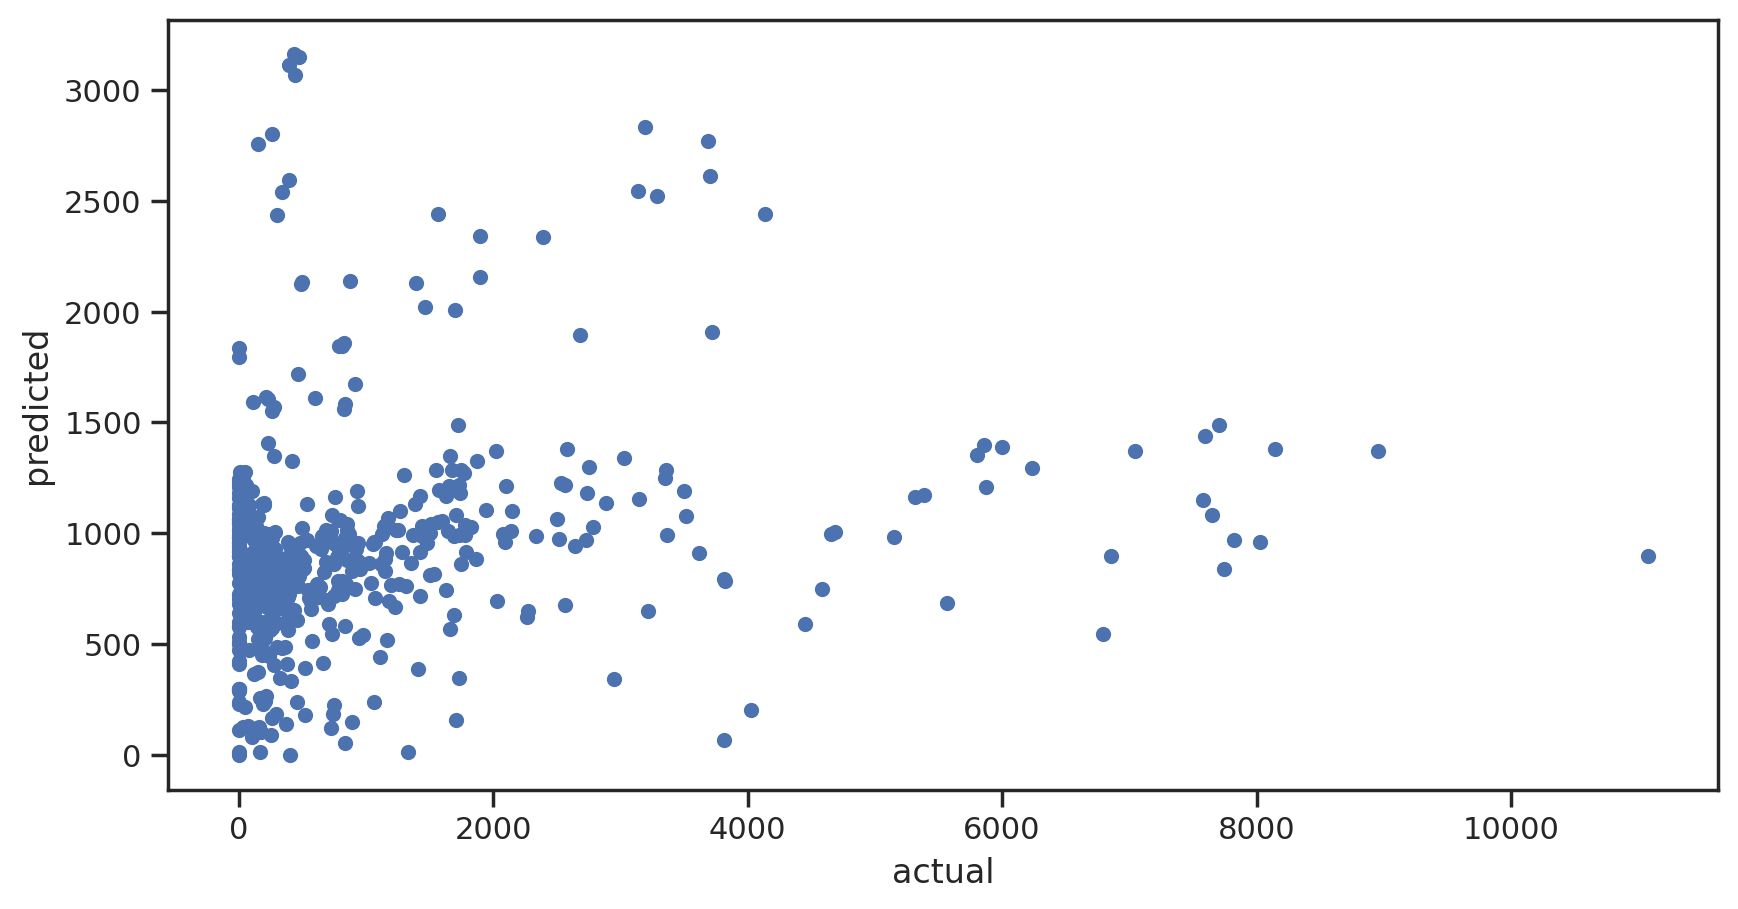

In [ ]:
df_from_LearnBolt.plot('actual','predicted',kind='scatter')

<Axes: >

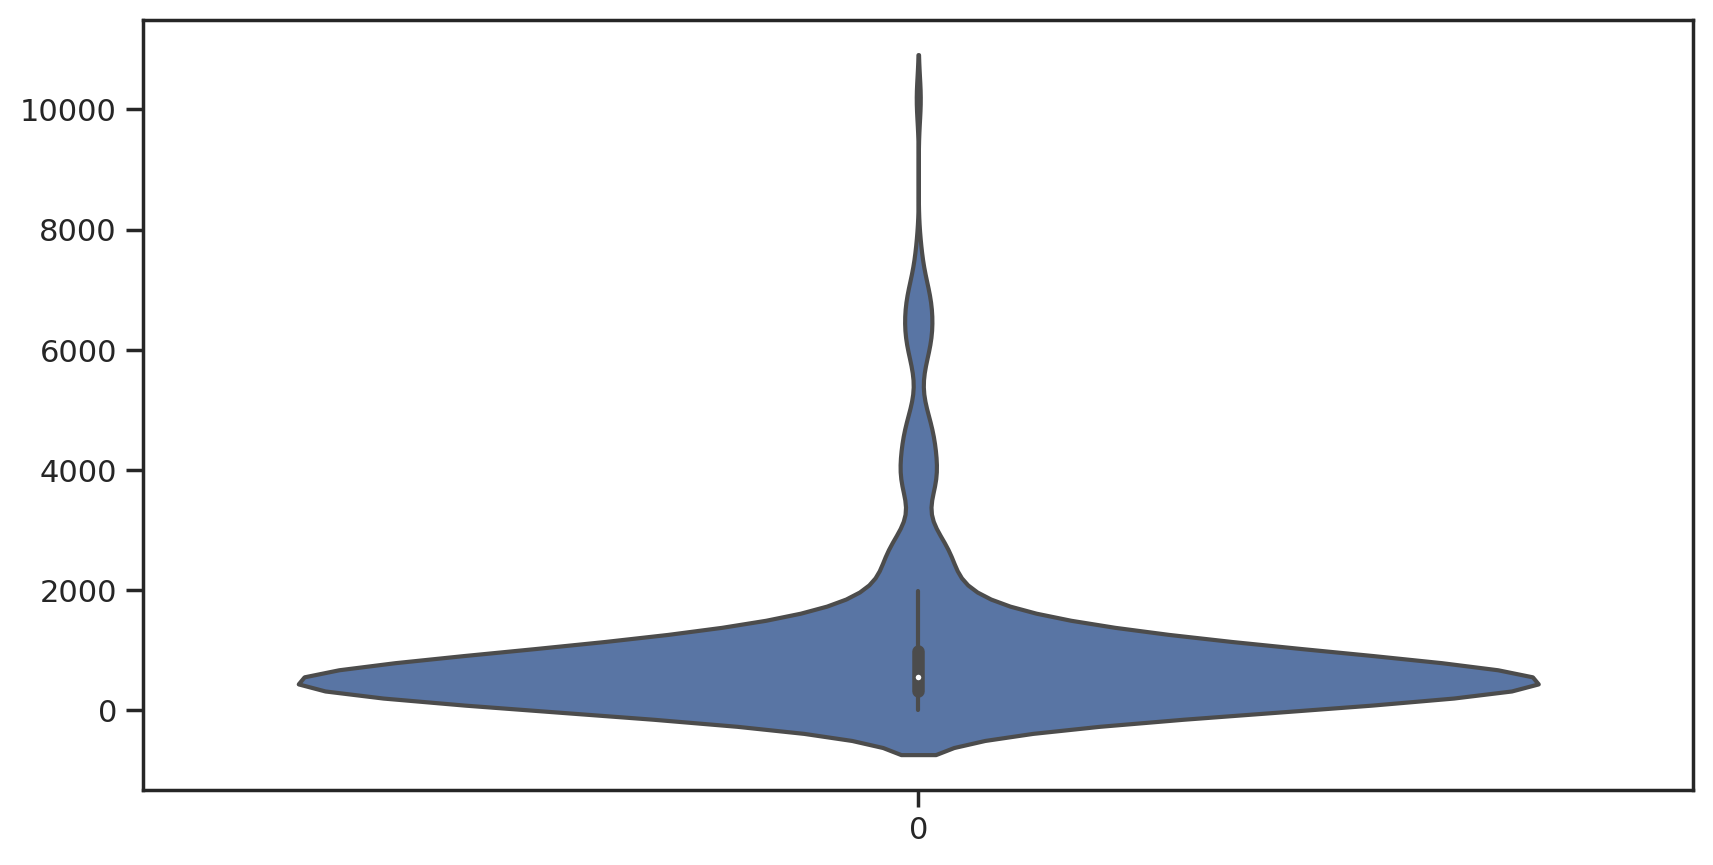

In [ ]:
sns.violinplot(df_from_LearnBolt['error'])

As expected, population density alone is not a great predictor of daily case rates. If we were to add Twitter data as an additional Spout and Join with the stream from CasesSpout, we could test if social media adds any  predictive power. 

##Handling two spouts at once - if you're interested

Below is a (non-working) skeleton code to do that. Feel free to take this up as a take-home exercise. 

In [ ]:
from streamparse.spout import Spout
import pandas as pd

twitter_stream = []

class TwitterSpout:
  outputs= ['date', 'code', 'num_covid_tweets','num_symptom_tweets','prop_symptom_tweets',
            'Relative Twitter Sentiment','Relative Twitter Loneliness','Relative Twitter Anxiety']
  # Position of next tuple in dataframe
  inx = 0
  # Overall stream tuple id
  tid = 0

  # Open the file as a dataframe
  def initialize(self, stormconf, context):
    # Load Twitter estimates data
    covid_tw_url = 'https://storage.googleapis.com/penn-cis5450/covid-data.csv'
    covid_tw_df = pd.read_csv(covid_tw_url)
    covid_tw_df.rename(columns={'Date':'date','State':'state','total_count':'num_symptom_tweets',
                                '# COVID Tweets':'num_covid_tweets'},inplace=True)

    cols_to_keep = ['state','date','num_covid_tweets','num_symptom_tweets', 'Relative Twitter Sentiment',
    'Relative Twitter Loneliness','Relative Twitter Anxiety']

    covid_tw_df = covid_tw_df[cols_to_keep]
    # Calculate proportion of tweets mentioning symptoms among the total COVID-19 tweets
    covid_tw_df['prop_symptom_tweets'] = covid_tw_df['num_symptom_tweets']/covid_tw_df['num_covid_tweets']    #self.covid_cases_df.dropna(inplace=True)
    self.covid_tw_df = covid_tw_df

  # Read one row, increment the pointer, return the
  # row as a list
  def next_tuple(self):
    tup = self.covid_tw_df.iloc[self.inx]
    self.inx = self.inx + 1

    # We'll wrap around if we exceed the size of the table
    if self.inx >= len(self.covid_tw_df):
      self.inx = 0

    # We have to turn the series into a list of columns.
    self.emit(tup.tolist(), tup_id=self.tid)
    self.tid = self.tid + 1

  # If a tuple was processed properly, do nothing
  def ack(self, tup_id):
    pass

  # If a tuple was processed incorrectly, we'll still
  # do nothing
  def fail(self, tup_id):
    pass

  # This would be omitted in the real code
  def emit(self, tuple, tup_id):
    global twitter_stream
    twitter_stream = twitter_stream + [tuple]

In [ ]:
twitter_stream = []
ts = TwitterSpout()

ts.initialize(None, None)
for i in range(500):
  ts.next_tuple()

df_from_TwitterSpout = pd.DataFrame(twitter_stream,columns=['state', 'date', 'num_covid_tweets',
                                                     'num_symptom_tweets', 'Relative Twitter Sentiment',
                                                     'Relative Twitter Loneliness',
                                                     'Relative Twitter Anxiety', 'prop_symptom_tweets'])
df_from_TwitterSpout

,state,date,num_covid_tweets,num_symptom_tweets,Relative Twitter Sentiment,Relative Twitter Loneliness,Relative Twitter Anxiety,prop_symptom_tweets
0,Alabama,2020-03-01,0,0,1.140701,0.266862,0.110401,NaN
1,Alabama,2020-03-02,0,0,0.719353,0.973367,0.037203,NaN
2,Alabama,2020-03-03,0,0,-0.050893,1.043078,0.096002,NaN
3,Alabama,2020-03-04,0,0,0.079578,0.878471,0.237131,NaN
4,Alabama,2020-03-05,0,0,-0.321438,0.469904,0.498409,NaN
...,...,...,...,...,...,...,...,...
495,Alaska,2020-07-13,647,21,-0.192054,-1.111296,0.731285,0.032457
496,Alaska,2020-07-14,624,30,-0.681729,-2.497716,0.459075,0.048077
497,Alaska,2020-07-15,648,25,-0.595621,0.218120,1.541895,0.038580
498,Alaska,2020-07-16,749,14,-1.430371,0.586617,0.780091,0.018692


In [ ]:
from streamparse.bolt import Bolt
from pystorm.component import Tuple
import pandas as pd
from pandasql import sqldf

twitter_and_cases_stream = []

class Twitter_And_Cases_JoinBolt:
  outputs=['date', 'code', 'pop_density', 'num_covid_tweets','num_symptom_tweets', 'prop_symptom_tweets',
           'Relative Twitter Sentiment','Relative Twitter Loneliness','Relative Twitter Anxiety','positiveIncrease']

  def initialize(self, stormconf, context):
    codes_url = 'https://storage.googleapis.com/penn-cis5450/us_states_codes.csv'
    codes_df = pd.read_csv(codes_url)
    codes_df.rename(columns={'State':'state','Code':'code'},inplace=True)
    codes_df.drop('Abbrev',axis=1,inplace=True)

    # US Population Density
    pop_url = 'https://storage.googleapis.com/penn-cis5450/us_pop_density.csv'
    pop_df = pd.read_csv(pop_url)
    pop_df.rename(columns={'State':'state','Density (/mi^2)':'pop_density'},inplace=True)

    # Merge state pop density and codes
    self.pop_df = pd.merge(pop_df,codes_df,on='state')

  def process(self, tup1, tup2): 
    covid_cases_df = pd.DataFrame([tup1],columns=['date','code','positiveIncrease'])
    covid_twitter_df = pd.DataFrame([tup2],columns=['state', 'date', 'num_covid_tweets',
                                                     'num_symptom_tweets', 'Relative Twitter Sentiment',
                                                     'Relative Twitter Loneliness',
                                                     'Relative Twitter Anxiety', 'prop_symptom_tweets'])
    pop_df = self.pop_df
    pre_incremental_results_1 = pd.merge(covid_cases_df, pop_df, on=['code'],how='inner')
    pre_incremental_results_2 = pd.merge(covid_twitter_df, codes_df, on=['state'],how='inner')

    incremental_results = pd.merge(pre_incremental_results_1,pre_incremental_results_2, on=['code','date'], how='inner')[['date', 'code', 'pop_density','num_covid_tweets','num_symptom_tweets','prop_symptom_tweets',
                  'Relative Twitter Sentiment','Relative Twitter Loneliness','Relative Twitter Anxiety','positiveIncrease']]
    if not(incremental_results.empty):
      self.emit(incremental_results.iloc[0].tolist())

  def emit(self, tuple):
    global twitter_and_cases_stream
    twitter_and_cases_stream = twitter_and_cases_stream + [tuple]


In [ ]:
twitter_and_cases_stream = []
jb = Twitter_And_Cases_JoinBolt()

jb.initialize(None, None)

#[TODO] Read from two parallel streams and send to Join Bolt 2

cols_to_keep=['date', 'code', 'pop_density', 'num_covid_tweets','num_symptom_tweets', 'prop_symptom_tweets',\
           'Relative Twitter Sentiment','Relative Twitter Loneliness','Relative Twitter Anxiety','positiveIncrease']
df_from_Twitter_And_Cases_JoinBolt = pd.DataFrame(twitter_and_cases_stream,columns=cols_to_keep)
#df_from_Twitter_And_Cases_JoinBolt

In [ ]:
# Learning Bolt

from streamparse.bolt import Bolt
from pystorm.component import Tuple
import pandas as pd
import creme.preprocessing
import creme.linear_model
from math import isnan

covidcases_from_pop_and_twitter_prediction_stream = []

class LearnBolt_2:
  outputs = ['predicted','actual','error']

  def initialize(self, stormconf, context):
    self.scaler = creme.preprocessing.StandardScaler()
    self.lin_reg = creme.linear_model.LinearRegression()
    self.state_code_one_hot = creme.preprocessing.OneHotEncoder('code')

  def process(self, tup):
    x = pd.Series(tup, index=['date', 'code', 'pop_density', 'num_covid_tweets', 'num_symptom_tweets',\
       'prop_symptom_tweets', 'Relative Twitter Sentiment',\
       'Relative Twitter Loneliness', 'Relative Twitter Anxiety',\
       'positiveIncrease'])
    if not(isnan(x.positiveIncrease)):
      #x = x.dropna(axis=0)
      x_onehot = pd.Series(self.state_code_one_hot.fit_one(x).transform_one(x))
      y = x['positiveIncrease']
      x = x.append(x_onehot).drop(['code','date','positiveIncrease'])

      x = self.scaler.fit_one(x).transform_one(x)
      yhat = self.lin_reg.predict_one(x)
      print('Predicted {}, actual {}, error {}'.format(yhat, y, abs(yhat - y)))
      self.emit([yhat,y,abs(yhat-y)])
      self.lin_reg.fit_one(x, y)
    else:
      print("positiveIncrease is nan")

  def emit(self, tuple):
    global covidcases_from_pop_and_twitter_prediction_stream
    covidcases_from_pop_and_twitter_prediction_stream = covidcases_from_pop_and_twitter_prediction_stream + [tuple]


In [ ]:
# Process Learning Bolt

covidcases_from_pop_and_twitter_prediction_stream = []
lb = LearnBolt_2()

lb.initialize(None, None)

for e in twitter_and_cases_stream:
  lb.process(e)

df_from_LearnBolt2 = pd.DataFrame(covidcases_from_pop_and_twitter_prediction_stream,columns=['predicted','actual','error'])